<h1 style="text-align: center;">Text content analysis</h1>

In [6]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from tqdm import tqdm
import os
import numpy as np
import pandas as pd

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import re
import nltk
from nltk.corpus import stopwords

from tashaphyne.stemming import ArabicLightStemmer
import pyarabic.araby as araby
import pyarabic.number as number
import pyarabic.trans as trans
from snowballstemmer import stemmer

In [7]:
#!pip install tashaphyne

In [8]:
#!pip install pyarabic

### 1. Data importation

In [9]:
data = pd.read_csv("/kaggle/input/data-sna/dataGroup.csv", index_col='Unnamed: 0')
data.head(3)

,post_id,text,post_text,shared_text,original_text,time,timestamp,image,image_lowquality,images,...,reaction_count,with,page_id,sharers,image_id,image_ids,was_live,header,video_ids,videos
0,1330025067400553,لكل من يسأل عن حمية اللوكارب LowCarb Diet 🥑🫒🍓🍖...,لكل من يسأل عن حمية اللوكارب LowCarb Diet 🥑🫒🍓🍖...,NaN,NaN,2021-08-31 10:51:53,1630403513,NaN,https://scontent.frba5-1.fna.fbcdn.net/v/t39.3...,[],...,47,[{'name': 'Diabète Maroc - régime Low Carb - ا...,1191348251268236,NaN,3.007771e+15,['3007770982772985'],False,Ayman Iguerhzifen‏Diabète Maroc - régime Low C...,NaN,NaN
1,1669619220107801,لا للحرمان مرضى السكري,لا للحرمان مرضى السكري,NaN,NaN,2022-12-29 16:26:35,1672327595,NaN,https://scontent.frba5-1.fna.fbcdn.net/v/t15.5...,[],...,1,"[{'name': 'Zanouba Diabete', 'link': '/zanouba...",1191348251268236,NaN,NaN,[],False,تمت مشاركة ‏منشور‏ بواسطة ‏‎Zanouba Diabete‎‏.,NaN,NaN
2,1669102223492834,السلام عليكم الله يخليكم بغيت نعرف واش كاين شي...,السلام عليكم الله يخليكم بغيت نعرف واش كاين شي...,NaN,NaN,2022-12-29 00:09:56,1672268996,NaN,https://scontent.frba5-1.fna.fbcdn.net/m1/v/t6...,[],...,2,[{'name': 'Diabète Maroc - régime Low Carb - ا...,1191348251268236,NaN,NaN,[],False,بالتحدي حققي احلامك‏Diabète Maroc - régime Low...,NaN,NaN


In [10]:
data.columns

Index(['post_id', 'text', 'post_text', 'shared_text', 'original_text', 'time',
       'timestamp', 'image', 'image_lowquality', 'images',
       'images_description', 'images_lowquality',
       'images_lowquality_description', 'video', 'video_duration_seconds',
       'video_height', 'video_id', 'video_quality', 'video_size_MB',
       'video_thumbnail', 'video_watches', 'video_width', 'likes', 'comments',
       'shares', 'post_url', 'link', 'links', 'user_id', 'username',
       'user_url', 'is_live', 'factcheck', 'shared_post_id', 'shared_time',
       'shared_user_id', 'shared_username', 'shared_post_url', 'available',
       'comments_full', 'reactors', 'w3_fb_url', 'reactions', 'reaction_count',
       'with', 'page_id', 'sharers', 'image_id', 'image_ids', 'was_live',
       'header', 'video_ids', 'videos'],
      dtype='object')

### 2. Comments extraction

In [11]:
post_id = []
post_user_id = []
commenter_id = []
comment_text = []

# In this part we're going to extract all comments of all posts

for i in tqdm(range(len(data))):
    for j in range(len(eval(data['comments_full'].loc[i]))):
        commenter_id.append(eval(data['comments_full'].loc[i])[j]['commenter_id'])
        comment_text.append(eval(data['comments_full'].loc[i])[j]['comment_text'])
        post_id.append(data["post_id"][i])
        post_user_id.append(data["user_id"][i])

100%|██████████| 210/210 [00:08<00:00, 23.48it/s]


In [12]:
# Making the data frame of comments
all_comment = pd.DataFrame(data={'post_id':post_id,'post_user_id':post_user_id,'commenter_id':commenter_id,'comment_text':comment_text})

In [13]:
all_comment.head(4)

,post_id,post_user_id,commenter_id,comment_text
0,1330025067400553,100006203372529,100003514921975,واش العنب مزيان للسكري؟
1,1330025067400553,100006203372529,704350801,اللي عندو كوليسترول ما تصلاحش ليه هاد الحمية؟
2,1330025067400553,100006203372529,100048010651681,Up
3,1330025067400553,100006203372529,100004315212633,Up


### 3. Text cleaning and preprocessing

In [14]:
#Remove stop words 
def remove_stop_words(text):
    stop_words = set(stopwords.words("arabic"))
    text = text.split()
    return " ".join([word for word in text if word not in stop_words])

#Tokenizing the_text :
def tokenize(s):
    return araby.tokenize(s)

#Normalize the text:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

# Remove-repeating_char :
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1\1', text)     # keep 2 repeat

# Remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Removing punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)

# Convert latin and numbers to arabic
def convert_arabic(text):
    text_words = []
    if text.isascii():
        text = text.lower()
        text = araby.strip_harakat(trans.convert(text,'buckwalter','arabic'))
    words = text.split(" ")
    for c in words:
        word = ''
        if c.isnumeric() and len(c) < 6:
            c = number.ArNumbers().int2str(c)
        # In this part we are going to change the 7 and 3 to there apropriate representatioion
        
        # Removing any word with more than 15 characters, all arabic words are less than 15 characters
        elif len(c)>12:
            c = ''
        for w in c:
            if w == '7':
                word +='ح'
            elif w == '3':
                word +='ع'
            elif w == '5':
                word +='خ'
            elif w == '9':
                word +='ق'
            else:
                word +=w
        text_words.append(word)
    return ' '.join(text_words)

# Stemmer : Remove suffixes and affixes 
def stemmer_light(text):
    ar_stemmer = ArabicLightStemmer()
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ar_stemmer.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)

# Remove diactrics
def remove_diactrics(text):
    return araby.strip_diacritics(text)

# Remove any non arabic character
def final_process(text):
    text = text.replace("[^\w\s]", "")
    text = re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD]+', ' ', text)
    text = text.split()
    return " ".join(text)

# Delete words that are less than 3 characters or in other type than string
def reduce_line(text):
    reduced = []
    for c in text.split(" "):
        if not c.isnumeric() and len(c)>2:
            red = c
            reduced.append(red)
    return ' '.join(reduced)

In [15]:
def data_clean(data, col='', conv_ar=True, stp_words=True, stem=True, tok=True, rm_emojis=True):
    data = data
    sentences = data[col]
    #Remove ـــ character wich is used a lot in arabic for exhibition
    sentences = [araby.strip_tatweel(text) for text in sentences]
    
    #Remove Punctiation 
    sentences = [remove_punctuation(text) for text in sentences]
    
    #Remove Emojis
    if rm_emojis==True :
        sentences = [remove_emojis(text) for text in sentences]
        
    #Remove Repeating character
    sentences = [remove_repeating_char(text) for text in sentences]
    
    #Remove arabic diacritics
    sentences = [remove_diactrics(text) for text in sentences]
    
    #Converte to arabic
    if conv_ar==True:
        sentences = [convert_arabic(text) for text in sentences]
    #Remove stop words
    if stp_words==True :
        sentences = [remove_stop_words(text) for text in sentences]
    
    # Stemmatize words
    if stem==True:
        sentences = [stemmer_light(text) for text in sentences]
    sentences = [normalize_arabic(text) for text in sentences]
    sentences = [araby.normalize_hamza(text, method="tasheel") for text in sentences]
    
    # Delete small words and numerics
    sentences = [reduce_line(text) for text in sentences]
    sentences = [final_process(text) for text in sentences]
    
    #Tokenize sentences
    if tok==True:
        sentences = [tokenize(text) for text in sentences]
    return sentences

In [18]:
#nltk.download('stopwords')

In [17]:
tex_cleaned = data_clean(all_comment, col='comment_text', tok=False)

In [19]:
text_comments = all_comment['comment_text']

In [20]:
print("Befor : ###")
print(list(text_comments)[55])
print("After : ###")
print(tex_cleaned[55])

Befor : ###
شكون كيعوضكم حتا هرااوني
After : ###
يعوض هراا


In [21]:
all_comment['processed_text'] = tex_cleaned

In [22]:
all_comment.head(4)

,post_id,post_user_id,commenter_id,comment_text,processed_text
0,1330025067400553,100006203372529,100003514921975,واش العنب مزيان للسكري؟,عنب مزي سكر
1,1330025067400553,100006203372529,704350801,اللي عندو كوليسترول ما تصلاحش ليه هاد الحمية؟,عند كوليسترول تصلاحش هاد
2,1330025067400553,100006203372529,100048010651681,Up,
3,1330025067400553,100006203372529,100004315212633,Up,


In [23]:
p = len(all_comment)
to_drop = []
for i in tqdm(range(p)):
    if len(all_comment.iloc[i][4]) == 0:
        to_drop.append(i)
all_comment.drop(to_drop, inplace=True)
all_comment.reset_index(drop=True, inplace=True)
post_info = all_comment[['post_id','post_user_id','commenter_id']]
all_comment = all_comment[['comment_text','processed_text']]

100%|██████████| 1875/1875 [00:00<00:00, 8051.58it/s]


In [24]:
all_comment.tail(7)

,comment_text,processed_text
1512,إلى كان مصرح بك عادي تستافدي ومن الأحسن ديري م...,مصرح عاد تستافد احسن دير ملف مرض مزمن بقاو رجع...
1513,أكيد تستافدي من الدواء ولبوندليط,كيد تستافد دواء بوندليط
1514,مامعنى اللوكارب,مامعني لوكارب
1515,Abdlekbir Ziraoui,دل كبر
1516,Souhail Ferhane Kilito,سهل رهن
1517,ماهو علاج مقاومة الانسولين؟,ماه علاج مقاوم انسول
1518,جميل\nشكرا خويا ايمن 💕,جميل شكر خوي


In [25]:
# Export results to facilitate reuse
# all_comment.to_pickle('cleaned_comments.pkl')

In [26]:
#comm = pd.read_pickle('cleaned_comments.pkl')
comm = all_comment

In [27]:
comm.head(4)

,comment_text,processed_text
0,واش العنب مزيان للسكري؟,عنب مزي سكر
1,اللي عندو كوليسترول ما تصلاحش ليه هاد الحمية؟,عند كوليسترول تصلاحش هاد
2,Ayman Iguerhzifen,غ رهزف ن
3,Ayman Iguerhzifen,غ رهزف ن


In [28]:
tex_ = data_clean(comm, col='processed_text', conv_ar=False, stp_words=False, stem=False, tok=True, rm_emojis=False)

In [29]:
word_count = Counter([word for words in tex_ for word in words])

In [30]:
print("Top 5 most frequent words in the text data:")
words = []
for word, count in word_count.most_common(50):
    print(word, count)
    words.append(word)

Top 5 most frequent words in the text data:
سكر 388
عند 130
ديال 96
طبيب 84
خبز 77
هاد 71
علي 71
دير 65
طالع 60
انسول 60
زاف 60
ريجيم 56
سلام 54
مزي 53
اين 48
خير 47
زنب 46
حال 44
رهزف 42
عاد 42
شكر 41
شرب 38
رجيم 36
حمل 35
خاص 35
حمد 35
قياس 34
قدر 34
عبر 33
شوف 31
اكل 31
ماء 31
رياض 31
لوكارب 29
ضرور 29
نسب 29
ساع 29
شافي 27
حاج 26
مسموح 26
سريع 25
مستعجل 24
ناس 24
ماش 24
طلع 23
دواء 23
عمل 23
حيد 23
مرض 23
شفاء 22


## 4. Topic Modeling

In [33]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

In [34]:
# We store our data after cleaning in a gensim dictionary, and then convert them to Bag Of Words format.
dictionary = gensim.corpora.Dictionary(tex_)

In [35]:
# Filter out tokens that appear in less than 20 documents (no_below = absolute number) or
# more than 0.7 documents (no_above = fraction of total corpus size).
# and keep only the first 1000 most frequent tokens (or keep all if None).
dictionary.filter_extremes(no_below=20, no_above=0.8, keep_n=1000)

In [36]:
bow_corpus = [dictionary.doc2bow(doc) for doc in tex_]

We apply topic modeling using the LdaMulticore function of gensim, specify the number of topics to be extracted from the corpus, the mapping between the identifiers of the words (integers) and the words (string) and the number of iterations to be performed in the corpus.

In [37]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 6, id2word = dictionary, passes = 1000)

In [38]:
topics = []
for idx, topic in lda_model.print_topics(-1) :
    print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic)

Topic: 0 -> Words: 0.229*"زنب" + 0.175*"حمد" + 0.130*"مسموح" + 0.129*"رياض" + 0.115*"دواء" + 0.073*"مزي" + 0.063*"شاء" + 0.048*"حاج" + 0.001*"غاد" + 0.001*"لوكارب"
Topic: 1 -> Words: 0.438*"سكر" + 0.112*"هاد" + 0.085*"عند" + 0.075*"خير" + 0.056*"حمل" + 0.045*"عاد" + 0.037*"طلع" + 0.033*"مزي" + 0.026*"عبر" + 0.025*"ريجيم"
Topic: 2 -> Words: 0.179*"علي" + 0.136*"سلام" + 0.106*"رهزف" + 0.105*"انسول" + 0.104*"شكر" + 0.103*"دير" + 0.063*"سريع" + 0.059*"لوكارب" + 0.053*"ندير" + 0.042*"عبر"
Topic: 3 -> Words: 0.164*"عند" + 0.103*"سكر" + 0.095*"حال" + 0.082*"شرب" + 0.073*"قياس" + 0.073*"قدر" + 0.067*"ماء" + 0.062*"ديال" + 0.050*"مرض" + 0.038*"ماش"
Topic: 4 -> Words: 0.242*"خبز" + 0.151*"اين" + 0.114*"رجيم" + 0.085*"شافي" + 0.073*"حيد" + 0.066*"يكس" + 0.066*"جميع" + 0.052*"قليل" + 0.047*"اثن" + 0.040*"ساع"
Topic: 5 -> Words: 0.146*"طبيب" + 0.117*"ديال" + 0.110*"سكر" + 0.104*"طالع" + 0.104*"زاف" + 0.061*"خاص" + 0.059*"ريجيم" + 0.054*"شوف" + 0.051*"نسب" + 0.042*"ضرور"


In [39]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tex_, dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.37219901092329466


In [40]:
all_topic_model = []
for i in range(len(topics)):
    str = topics[i].split(' + ')
    topic_model = []
    for j in range(7):
        weight = str[j][0:5]
        word = str[j][7:len(str[j])-1]
        topic_model.append((weight, word))
    all_topic_model.append(topic_model)

In [41]:
df_topic_model = pd.DataFrame(all_topic_model)
df_topic_model.rename(index = {0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5", 5: "Topic 6", 6: "Topic 7", 7: "Topic 8", 8: "Topic 9", 9: "Topic 10"})

,0,1,2,3,4,5,6
Topic 1,"(0.229, زنب)","(0.175, حمد)","(0.130, مسموح)","(0.129, رياض)","(0.115, دواء)","(0.073, مزي)","(0.063, شاء)"
Topic 2,"(0.438, سكر)","(0.112, هاد)","(0.085, عند)","(0.075, خير)","(0.056, حمل)","(0.045, عاد)","(0.037, طلع)"
Topic 3,"(0.179, علي)","(0.136, سلام)","(0.106, رهزف)","(0.105, انسول)","(0.104, شكر)","(0.103, دير)","(0.063, سريع)"
Topic 4,"(0.164, عند)","(0.103, سكر)","(0.095, حال)","(0.082, شرب)","(0.073, قياس)","(0.073, قدر)","(0.067, ماء)"
Topic 5,"(0.242, خبز)","(0.151, اين)","(0.114, رجيم)","(0.085, شافي)","(0.073, حيد)","(0.066, يكس)","(0.066, جميع)"
Topic 6,"(0.146, طبيب)","(0.117, ديال)","(0.110, سكر)","(0.104, طالع)","(0.104, زاف)","(0.061, خاص)","(0.059, ريجيم)"


In [49]:
# ! pip install pyLDAvis

In [50]:
import pyLDAvis.gensim_models

ModuleNotFoundError: No module named 'pyLDAvis.gensim_models'

In [44]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.176776  0.000899       1        1  12.971448
1     -0.208479  0.008960       2        1  12.675891
7     -0.121349 -0.235025       3        1  11.828687
4      0.293490  0.074931       4        1  11.812876
8     -0.162447  0.065860       5        1   9.905585
9      0.063867  0.154861       6        1   9.854814
5     -0.057733  0.196808       7        1   9.210765
6      0.220927 -0.314867       8        1   7.805103
2     -0.115079 -0.054691       9        1   7.555742
3      0.263579  0.102264      10        1   6.379089, topic_info=     Term        Freq       Total Category  logprob  loglift
33    انا  133.000000  133.000000  Default  30.0000  30.0000
0     سكر  364.000000  364.000000  Default  29.0000  29.0000
14   الله  148.000000  148.000000  Default  28.0000  28.0000
27    عند  105.000000  105.000000  Default  27.0000  27.0000
13    اخت   94.000000   94.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
2     واش    0.100865   74.145978  Topic10  -7.7258  -3.8479
43    زاف    0.100865   58.252449  Topic10  -7.7258  -3.6066
17    ممك    0.100865   28.044927  Topic10  -7.7258  -2.8756
49    خير    0.100865   44.491736  Topic10  -7.7258  -3.3371
1   مزيان    0.100864   73.261361  Topic10  -7.7258  -3.8359

[455 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
37        1  0.243672   احس
37        7  0.696205   احس
13        4  0.994946   اخت
20        5  0.990443   اكل
50        1  0.797975   الا
...     ...       ...   ...
75        5  0.773679   وزن
24        3  0.967150   ولد
35        4  0.962335  يشاف
64        5  0.957623  يكون
9        10  0.968921   يمن

[141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 8, 5, 9, 10, 6, 7, 3, 4])

## Sentiment analysis

In [31]:
sentiment = pd.read_csv('/kaggle/input/data-sna/Sentiment_Anaysis.csv', index_col='Unnamed: 0')

In [32]:
sentiment.head(4)

,Twits,label
0,what happens,neu
1,😞😞,neg
2,ان شاء الله,neu
3,بالتوفيق ان شاء الله,pos


In [33]:
sentiment.shape

(52210, 2)

This is a good dataset it contains lot of labeled tweets, but we need to reduce its size to optimize the computation

In [34]:
neg = sentiment.loc[(sentiment.label=='neg')].sample(frac=0.4, random_state=33)
pos = sentiment.loc[(sentiment.label=='pos')].sample(frac=0.4, random_state=33)
neu = sentiment.loc[(sentiment.label=='neu')].sample(frac=0.4, random_state=33)

In [35]:
reduced = pd.concat([neg,pos,neu])

In [36]:
reduced.reset_index(drop=True, inplace=True)

In [37]:
reduced.shape

(20884, 2)

In [38]:
reduced.head(4)

,Twits,label
0,اودي ناس د العالم القروي معندهومش مساكن تا الك...,neg
1,حسبنا الله ونعم الوكيل حرروا_المعتقلين,neg
2,: غارات مكثفه على قاعدة الوطيه الان والطيران ب...,neg
3,"وللـ ""علامة"" انو من فترة كان عم يقول انو الفير...",neg


In [39]:
sentiment_proce = data_clean(reduced, col='Twits', tok=False)

In [40]:
sentiment_proce_tok = data_clean(reduced, col='Twits', tok=True)

In [41]:
sentiment_proce[12:13]

['حتفل عالم يوم ذكري مءو حرب عالم اولي رغم تجرب مرير تعظ انس حروب ماسي']

In [42]:
reduced['process'] = sentiment_proce
reduced['process_tok'] = sentiment_proce_tok

In [43]:
reduced.head(4)

,Twits,label,process,process_tok
0,اودي ناس د العالم القروي معندهومش مساكن تا الك...,neg,ناس عالم قرو معندهومش كونكسي اين معندوش تلفز ت...,"[ناس, عالم, قرو, معندهومش, كونكسي, اين, معندوش..."
1,حسبنا الله ونعم الوكيل حرروا_المعتقلين,neg,حسب نعم وكيل,"[حسب, نعم, وكيل]"
2,: غارات مكثفه على قاعدة الوطيه الان والطيران ب...,neg,غار مكثف قاعد وطيه طير يولع لاب ردوغا قريب مين...,"[غار, مكثف, قاعد, وطيه, طير, يولع, لاب, ردوغا,..."
3,"وللـ ""علامة"" انو من فترة كان عم يقول انو الفير...",neg,علام قول فيروس يخوف,"[علام, قول, فيروس, يخوف]"


In [44]:
# Drop any empty values
p = len(reduced)
to_drop = []
for i in tqdm(range(p)):
    if len(reduced.iloc[i][2]) == 0:
        to_drop.append(i)
reduced.drop(to_drop, inplace=True)
reduced.reset_index(drop=True, inplace=True)

100%|██████████| 20884/20884 [00:01<00:00, 11817.51it/s]


In [45]:
processed_text_tok = data_clean(comm, col='comment_text', tok=True)

In [46]:
comm['processed_text_tok'] = processed_text_tok

In [47]:
comm = comm[['comment_text','processed_text','processed_text_tok']]
comm.head(4)

,comment_text,processed_text,processed_text_tok
0,واش العنب مزيان للسكري؟,عنب مزي سكر,"[عنب, مزي, سكر]"
1,اللي عندو كوليسترول ما تصلاحش ليه هاد الحمية؟,عند كوليسترول تصلاحش هاد,"[عند, كوليسترول, تصلاحش, هاد]"
2,Ayman Iguerhzifen,غ رهزف ن,"[غ, رهزف, ن]"
3,Ayman Iguerhzifen,غ رهزف ن,"[غ, رهزف, ن]"


In [48]:
# Drop any empty values
p = len(comm)
to_drop = []
for i in tqdm(range(p)):
    if len(comm['processed_text_tok'].iloc[i]) == 0:
        to_drop.append(i)
comm.drop(to_drop, inplace=True)
comm.reset_index(drop=True, inplace=True)

100%|██████████| 1519/1519 [00:00<00:00, 76633.40it/s]


In [49]:
data_for_train = reduced[['process','process_tok','label']]

In [50]:
data_for_test = comm[['processed_text', 'processed_text_tok']]

In [51]:
data_for_train.head(4)

,process,process_tok,label
0,ناس عالم قرو معندهومش كونكسي اين معندوش تلفز ت...,"[ناس, عالم, قرو, معندهومش, كونكسي, اين, معندوش...",neg
1,حسب نعم وكيل,"[حسب, نعم, وكيل]",neg
2,غار مكثف قاعد وطيه طير يولع لاب ردوغا قريب مين...,"[غار, مكثف, قاعد, وطيه, طير, يولع, لاب, ردوغا,...",neg
3,علام قول فيروس يخوف,"[علام, قول, فيروس, يخوف]",neg


In [52]:
data_for_test.head(4)

,processed_text,processed_text_tok
0,عنب مزي سكر,"[عنب, مزي, سكر]"
1,عند كوليسترول تصلاحش هاد,"[عند, كوليسترول, تصلاحش, هاد]"
2,غ رهزف ن,"[غ, رهزف, ن]"
3,غ رهزف ن,"[غ, رهزف, ن]"


### Extracting all words from both datasets

In [53]:
all_lines = pd.concat([data_for_test.processed_text_tok, data_for_train.process_tok])

In [54]:
all_lines = pd.DataFrame({'lines':all_lines})

In [55]:
all_lines.shape

(20763, 1)

In [56]:
flat_words = [i for sublist in data_for_test.processed_text_tok for i in sublist]
vocab1, counts = np.unique(flat_words, return_counts=True)

In [57]:
flat_words = [i for sublist in data_for_train.process_tok for i in sublist]
vocab2, counts = np.unique(flat_words, return_counts=True)

In [58]:
same = []
for i in vocab1:
    if i in vocab2:
        same.append(i)

In [59]:
print("We have {} common words in the the two vocabs, {:.2f}% of the words in the testing vocab are in the training vocab.".format(len(same),len(same)/len(vocab1)*100))

We have 1852 common words in the the two vocabs, 61.14% of the words in the testing vocab are in the training vocab.


In [60]:
flat_words = [i for sublist in all_lines.lines for i in sublist]
vocab, counts = np.unique(flat_words, return_counts=True)
vocab = vocab[np.argsort(counts)[::-1]]

In [61]:
print("We have {} words in all concatenated Facebook Comments and Tweets of sentiments dataset".format(len(flat_words)))
print("And in all of these words we have a vocabulary of {} words which means {:.2f}% of all words.".format(len(vocab),(len(vocab)/len(flat_words))*100))

We have 149984 words in all concatenated Facebook Comments and Tweets of sentiments dataset
And in all of these words we have a vocabulary of 22757 words which means 15.17% of all words.


In [62]:
bigest = 0
for i in flat_words:
    if len(i) > bigest:
        bigest = len(i)
        the_one = i
print(bigest," it's "+the_one)

12  it's زكرياءتحياتي


In [63]:
vocab

array(['جزاءر', 'علي', 'عند', ..., 'قعقور', 'قعط', '01خق44خق'],
      dtype='<U12')

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
vectorizer = TfidfVectorizer(encoding ='<U12', min_df=15, max_df=0.7, vocabulary=vocab, dtype=np.int16)
vector = vectorizer.fit_transform(data_for_train.process).toarray()

In [66]:
vector = pd.DataFrame(vector, columns=vectorizer.get_feature_names_out())

In [67]:
vector['label'] = data_for_train.label

In [68]:
vector.replace({"neg":-1,"pos":1,"neu":0}, inplace=True)

In [69]:
vector.head()

,جزاءر,علي,عند,ناس,دول,خير,حال,لبنان,قول,شعب,...,قفر,قفاطن,قفاا,قفا,قعيي,قعل,قعقور,قعط,01خق44خق,label
0,0.0,0.0,0.0,0.172529,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.329938,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [70]:
vectorizer = TfidfVectorizer(encoding ='<U12', min_df=15, max_df=0.7, vocabulary=vocab, dtype=np.int16)
vector_test = vectorizer.fit_transform(data_for_test.processed_text).toarray()

In [71]:
vector_test = pd.DataFrame(vector_test, columns=vectorizer.get_feature_names_out())

In [72]:
vector_test.head()

,جزاءر,علي,عند,ناس,دول,خير,حال,لبنان,قول,شعب,...,قفرت,قفر,قفاطن,قفاا,قفا,قعيي,قعل,قعقور,قعط,01خق44خق
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.361817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint

In [74]:
X_train, X_test, y_train, y_test = train_test_split(vector.iloc[:,:-1],vector.iloc[:,-1], random_state=0)

In [75]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [76]:
y_pred = rf.predict(X_test)

In [77]:
print(" Accuracy : {}\n Precision : {}\n Recall : {}".format(accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average=None), recall_score(y_test,y_pred,average=None)))

 Accuracy : 0.7391394720432343
 Precision : [0.8592437  0.70858806 0.71698113]
 Recall : [0.54642619 0.92266869 0.44970414]


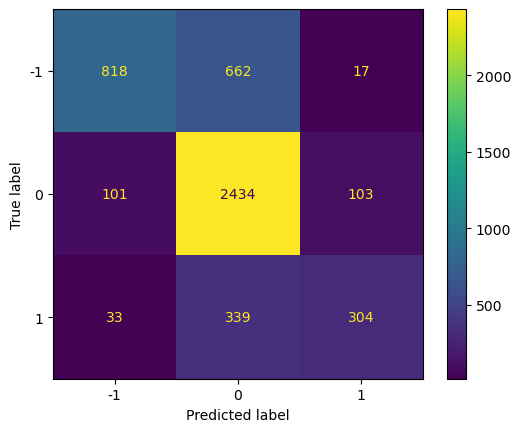

In [78]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_).plot();

In [360]:
from sklearn.naive_bayes import MultinomialNB

In [361]:
clf = MultinomialNB(force_alpha=True)
clf.fit(X_train, y_train)

MultinomialNB(force_alpha=True)

In [363]:
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.6668054977092878

In [364]:
from sklearn.neighbors import KNeighborsClassifier

In [367]:
clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=20)

In [368]:
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.5651811745106206

In [127]:
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

In [128]:
y_trains = to_categorical(y_train, num_classes=3)

In [135]:
classif = Sequential()
classif.add(Dense(500, activation="relu", input_shape = (X_train.shape[1],)))
classif.add(Dense(500, activation="relu"))
classif.add(Dense(100, activation="relu"))
classif.add(Dense(50, activation="relu"))
classif.add(Dense(3, activation="softmax"))
classif.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               11379000  
                                                                 
 dense_13 (Dense)            (None, 500)               250500    
                                                                 
 dense_14 (Dense)            (None, 100)               50100     
                                                                 
 dense_15 (Dense)            (None, 50)                5050      
                                                                 
 dense_16 (Dense)            (None, 3)                 153       
                                                                 
Total params: 11,684,803
Trainable params: 11,684,803
Non-trainable params: 0
_________________________________________________________________


In [136]:
classif.compile(loss="categorical_crossentropy", optimizer= Adam(lr=0.001), metrics=['accuracy'])
classif.fit(X_train, y_trains, epochs = 10, shuffle = True, batch_size=128, verbose=2)

Epoch 1/10
113/113 - 12s - loss: 0.7626 - accuracy: 0.6622 - 12s/epoch - 106ms/step
Epoch 2/10
113/113 - 11s - loss: 0.3041 - accuracy: 0.8839 - 11s/epoch - 95ms/step
Epoch 3/10
113/113 - 11s - loss: 0.1118 - accuracy: 0.9622 - 11s/epoch - 94ms/step
Epoch 4/10
113/113 - 11s - loss: 0.0662 - accuracy: 0.9758 - 11s/epoch - 98ms/step
Epoch 5/10
113/113 - 11s - loss: 0.0551 - accuracy: 0.9780 - 11s/epoch - 95ms/step
Epoch 6/10
113/113 - 11s - loss: 0.0465 - accuracy: 0.9800 - 11s/epoch - 94ms/step
Epoch 7/10
113/113 - 11s - loss: 0.0417 - accuracy: 0.9808 - 11s/epoch - 99ms/step
Epoch 8/10
113/113 - 11s - loss: 0.0382 - accuracy: 0.9815 - 11s/epoch - 96ms/step
Epoch 9/10
113/113 - 11s - loss: 0.0361 - accuracy: 0.9803 - 11s/epoch - 95ms/step
Epoch 10/10
113/113 - 11s - loss: 0.0353 - accuracy: 0.9832 - 11s/epoch - 98ms/step


In [143]:
y_pred = classif.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

151/151 [==============================] - 3s 17ms/step


In [144]:
y_pred

array([1, 0, 0, ..., 0, 2, 2])

In [145]:
y_tests = np.argmax(to_categorical(y_test),axis=1)

In [147]:
accuracy_score(y_tests,y_pred)

0.5362710455206817

### Let's predict sentiments of comments

In [79]:
comment_sentiment = rf.predict(vector_test)

In [80]:
comm['sentiment'] = comment_sentiment

In [81]:
# Sample of negatively classified commets
comm['comment_text'].loc[comm['sentiment']==-1][0:5].tolist()

['اللهم شفاؤك شفاء لا يغادر سقما..التقيؤ ممكن من لاسيطون عبري ليها لاسيطون..أما اللوكارب فهو طريق النجاة إليها وإليك خصوصا.. الله المستعان',
 'الابنة نتاعك طالع ليها السكر اوعندها لاسيطون طالع ضروري تشوفي الطبيب او تمشي للمستشفى لقريب ليكم .....الله اجيب ليها الشفاء',
 'حتى في المجموعة ممكن تحطين وتسألي كلشي غيجوبك وكاين اطر طبية وناس كتفهم احسن منا وكنتقسموا معلومات كثيرة',
 'الحمية الحمية. اللهم شفاء لا يغادر سقما ولا يترك ألما لجميع المرضى',
 'إلى احتجت بعض النصاءح مرحبا اخي الكريم ويقول ناس ازمان سأل لمجرب لا سأل الطبيب بالأخص في الأمراض المزمنة تحياتي']

In [82]:
# Sample of positively classified commets
comm['comment_text'].loc[comm['sentiment']==1][15:20].tolist()

['ضرب ليه واحد 4 وحدات انسولين ينزل شوية، وضروري من المتابعة مع الطبيب. مرة مرة عبرو ليه. غادي يولي بخير ان شاء الله',
 'الله يحفظك والله أقدرك عزيزتي',
 'كان عندي سكري الحمل و الحمد لله كولشي داز مزيان و ولدي تزاد بخير و على خير مابه والو الله يحفظه و يحفظك وليدات المسلمين كاملين، واخا باقي كنعاني من مقاومة الانسولين و حاليا في مرحلة ماقبل السكري و لكن الحمد لله على كل حال باقية متبعة ريجيم ديالي و الحركة و الدوا و الشفاء من عند الله سبحانه\n\nالتزمي بالريجيم ديالك و المراقبة و الحركة ما أمكن و شربي الما مزيان و كولي مزيان كثري من الألياف و البروتينات و مايكون غير الخير إن شاء الله.\n\nالله يتمم حملك على خير',
 'ليشفينا كاملين ياربي',
 'الله يفكك على خير']

In [84]:
# Sample of neutrally classified commets
comm['comment_text'].loc[comm['sentiment']==0][30:33].tolist()

['مهتمة', 'معرفتش اختي حتى انا كناخدهم 70, درهم', 'شكون كيعوضكم حتا هرااوني']

As we can see the results are not bad and expected based on the models accuracy, we can see some well classified comments

In [85]:
# Replacing labels by there names
comm.replace({1:"pos",-1:"neg",0:"neu"}, inplace=True)

In [87]:
comm.to_pickle('Comment_sentiments.pkl')

### Autoencoder for dimentionality deruction

In [88]:
 counts = comm['sentiment'].value_counts()

In [89]:
counts

neu    1351
pos     101
neg      67
Name: sentiment, dtype: int64

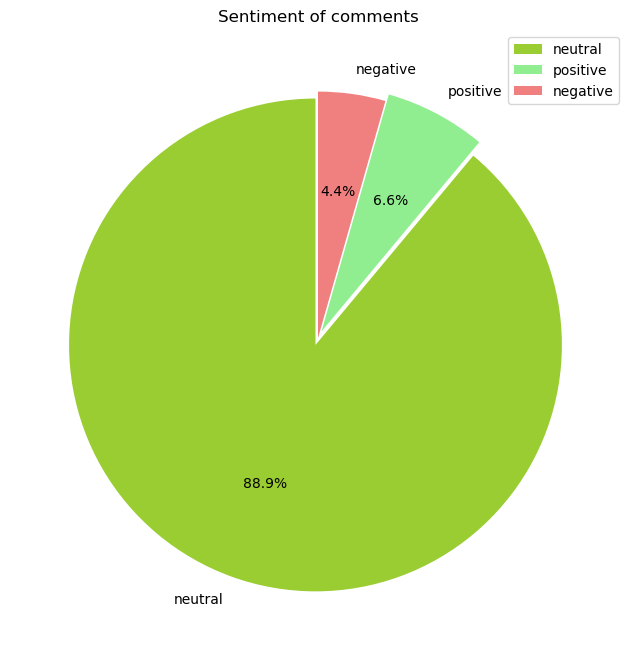

In [92]:
fig = plt.figure(figsize=(8, 8))

# Pie chart

#colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
colors = ['yellowgreen', 'lightgreen','lightcoral']
labels = ['neutral','positive', 'negative']
explod_list = [0.03, 0.03, 0]
plt.pie(counts, colors=colors, labels=labels, autopct='%1.1f%%', explode=explod_list, startangle=90)

# Ajouter un titre
plt.title('Sentiment of comments')

# Afficher le graphique
plt.legend(loc='upper right')
plt.savefig("Sentiments.png", dpi=300)